In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel("Model_test_MKB.xlsx", sheet_name="Datasets")

df = df.drop(columns=['KvK', 'Handelsnaam', 'Contactpersoon WP'])

X = df.drop(columns=['Comeback (0,1)'])
y = df['Comeback (0,1)']

In [ ]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in categorical_cols:
    X[col] = X[col].astype(str)


In [ ]:
preprocessor_rf = ColumnTransformer(transformers=[
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols),
    ('num', SimpleImputer(strategy='median'), numeric_cols)
])


In [ ]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Status', 'Challenge Type',
                                                   'Vak 1', 'Language',
                                                   'Duration', 'Academic Year',
                                                   'Student Time Investment',
                                                   'Company Time Investment',
                                                   'Project_Starting_Date(YYYY_MM)',
                                                   'Regulier/Multidisciplinair',
                                                   'Kennisinstelling',
                                                   'Opleidingsniveau',
                                                   'Industry', 'Location',
                                                   '# of followers']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['# of FTE'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [ ]:
y_prob = rf_pipeline.predict_proba(X_test)[:, 1]
y_pred = rf_pipeline.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Confusion Matrix:
 [[163   3]
 [ 16  12]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94       166
           1       0.80      0.43      0.56        28

    accuracy                           0.90       194
   macro avg       0.86      0.71      0.75       194
weighted avg       0.89      0.90      0.89       194

ROC-AUC: 0.9072719449225474


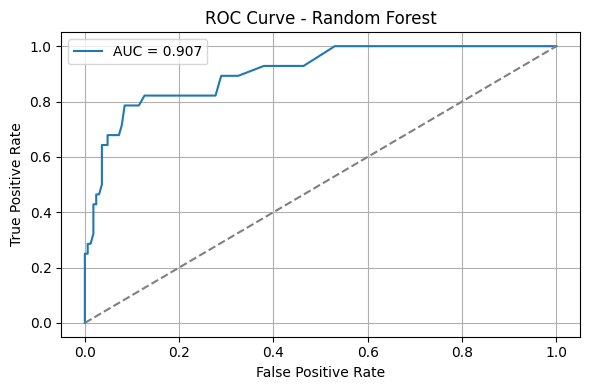

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


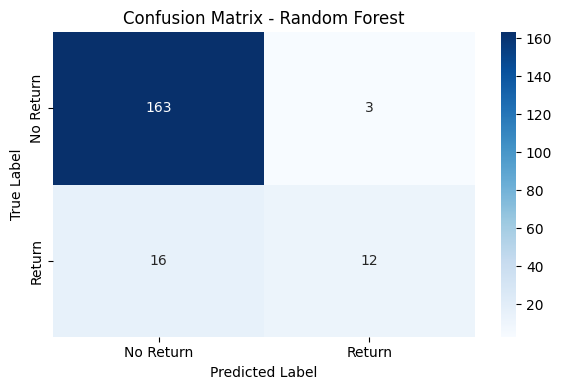

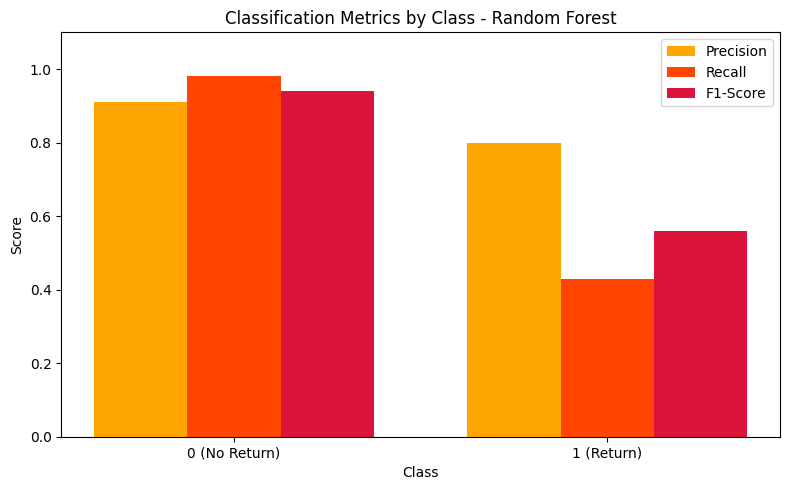

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

conf_matrix_rf = np.array([[163, 3],
                           [16, 12]])

rf_metrics = {
    "Class": ["0 (No Return)", "1 (Return)"],
    "Precision": [0.91, 0.80],
    "Recall": [0.98, 0.43],
    "F1-Score": [0.94, 0.56]
}

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Return", "Return"],
            yticklabels=["No Return", "Return"])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.25
index = np.arange(len(rf_metrics["Class"]))

for i, metric in enumerate(["Precision", "Recall", "F1-Score"]):
    ax.bar(index + i * bar_width, rf_metrics[metric],
           width=bar_width, label=metric,
           color=["orange", "orangered", "crimson"][i])

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_title('Classification Metrics by Class - Random Forest')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(rf_metrics["Class"])
ax.set_ylim(0, 1.1)
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
encoder = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
feature_names = list(encoder.get_feature_names_out(categorical_cols)) + numeric_cols


importances = rf_pipeline.named_steps['classifier'].feature_importances_
imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(imp_df.head(15))


                                     Feature  Importance
3                       Status_4. Geen Match    0.041999
568                                 # of FTE    0.035741
227                             Industry_nan    0.034682
0              Status_1. Challenge ingediend    0.031878
374                             Location_nan    0.029910
567                       # of followers_nan    0.017447
16        Vak 1_AI Masterclass Rabo - mrt 25    0.016378
2                Status_3. Definitieve match    0.014499
190  Project_Starting_Date(YYYY_MM)_2025-Mar    0.013413
226                 Industry_Technology & IT    0.012623
240                       Location_Amsterdam    0.012543
533                        # of followers_74    0.012487
192  Project_Starting_Date(YYYY_MM)_2025-Sep    0.012166
217              Industry_Business & Finance    0.011098
7                          Challenge Type_AI    0.010802


**Full Code**

====== Confusion Matrix ======
[[163   3]
 [ 16  12]]

====== Classification Report ======
Accuracy: 0.902
ROC-AUC: 0.907

Class 0:
  Precision: 0.91
  Recall:    0.98
  F1-Score:  0.94

Class 1:
  Precision: 0.80
  Recall:    0.43
  F1-Score:  0.56


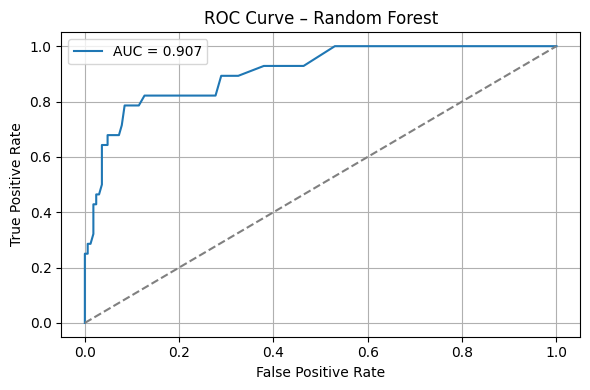

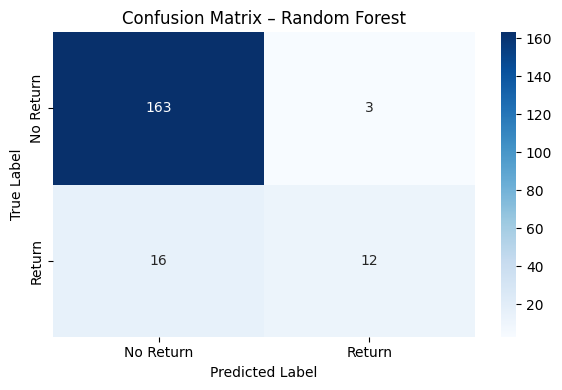

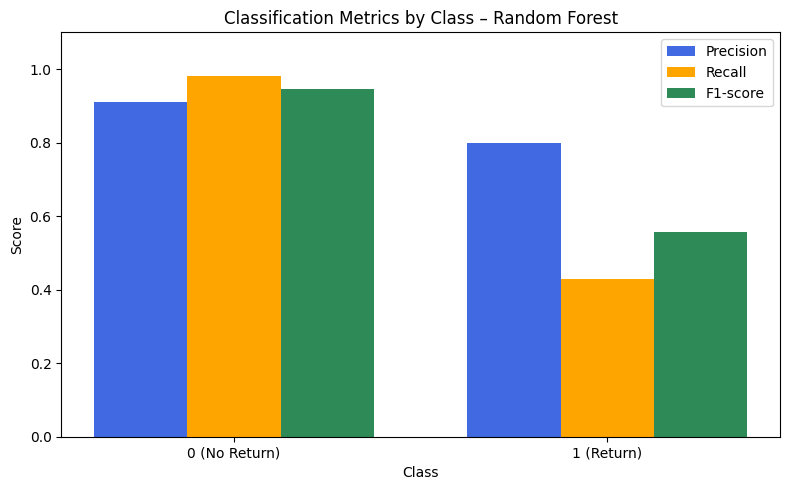

/tmp/ipython-input-9-1638758565.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Abs_Importance", y="Feature", data=top_features, palette="viridis")


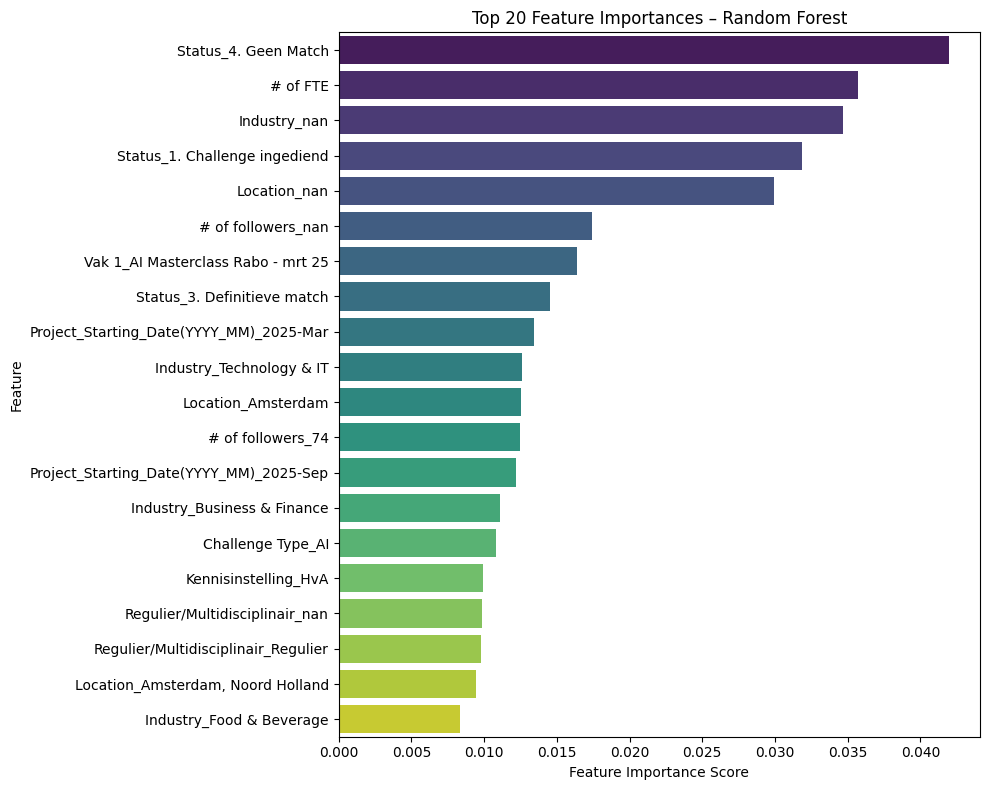

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Data ===
df = pd.read_excel("Model_test_MKB.xlsx", sheet_name="Datasets")
df.drop(columns=['KvK', 'Handelsnaam', 'Contactpersoon WP'], inplace=True)

X = df.drop(columns=['Comeback (0,1)'])
y = df['Comeback (0,1)']

# === Preprocessing ===
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in categorical_cols:
    X[col] = X[col].astype(str)

preprocessor = ColumnTransformer(transformers=[
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols),
    ('num', SimpleImputer(strategy='median'), numeric_cols)
])

# === Pipeline ===
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Fit Model ===
pipeline.fit(X_train, y_train)

# === Predict ===
y_prob = pipeline.predict_proba(X_test)[:, 1]
y_pred = pipeline.predict(X_test)

# === Evaluation ===
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)

print("====== Confusion Matrix ======")
print(conf_matrix)

print("\n====== Classification Report ======")
print(f"Accuracy: {accuracy:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
for cls in ["0", "1"]:
    print(f"\nClass {cls}:")
    print(f"  Precision: {report[cls]['precision']:.2f}")
    print(f"  Recall:    {report[cls]['recall']:.2f}")
    print(f"  F1-Score:  {report[cls]['f1-score']:.2f}")

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Confusion Matrix Heatmap ===
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Return", "Return"],
            yticklabels=["No Return", "Return"])
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# === Classification Metrics Bar Plot ===
metrics = ["precision", "recall", "f1-score"]
classes = ["0 (No Return)", "1 (Return)"]
scores = {metric: [report["0"][metric], report["1"][metric]] for metric in metrics}

fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.25
index = np.arange(len(classes))

for i, metric in enumerate(metrics):
    ax.bar(index + i * bar_width, scores[metric], width=bar_width,
           label=metric.capitalize(),
           color=["royalblue", "orange", "seagreen"][i])

ax.set_xlabel("Class")
ax.set_ylabel("Score")
ax.set_title("Classification Metrics by Class – Random Forest")
ax.set_xticks(index + bar_width)
ax.set_xticklabels(classes)
ax.set_ylim(0, 1.1)
ax.legend()
plt.tight_layout()
plt.show()

# === Feature Importance ===
encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder']
feature_names = list(encoder.get_feature_names_out(categorical_cols)) + numeric_cols

importances = pipeline.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df["Abs_Importance"] = importance_df["Importance"].abs()
top_features = importance_df.sort_values("Abs_Importance", ascending=False).head(20)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x="Abs_Importance", y="Feature", data=top_features, palette="viridis")
plt.title("Top 20 Feature Importances – Random Forest")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
